# Efficient k-subset-sum distributions — cleaned demo

This notebook demonstrates the *post-transient translation* phenomenon used in the paper.

What it does:
1. Computes the k-subset-sum distribution for `{0,1,...,n}` via DP (ground truth for moderate `n`).
2. Applies the **k-th discrete derivative** using offsets `1..k`.
3. Extracts **peak positions** (where the derivative is non-zero).
4. At the transient boundary `n0`, it infers **translation speeds** by comparing peaks at `n0` and `n0+1`.
5. For a target `n`, it predicts peak positions by shifting with the inferred speeds and compares to DP+derivative.
6. Plots the derivative twice (two separate figures): **ground-truth peaks** vs **shift-predicted peaks**.

Notes:
- Choose the transient convention with `TRANSIENT_MODE` (see the parameter cell).
- For larger `n`, DP becomes slow; start with small/moderate values.


In [1]:
# --- Setup (run once) ---
from __future__ import annotations

from collections import Counter
from typing import List, Tuple, Dict

import matplotlib.pyplot as plt


## Core functions (DP, derivative, peak extraction)

In [2]:
def k_subset_sum_distribution(n: int, k: int) -> Tuple[List[int], List[int]]:
    """
    Exact distribution of sums of k-element subsets of {0,1,...,n}.
    Returns:
      sums  : sorted list of achievable sums
      freqs : corresponding counts (#subsets achieving each sum)
    """
    dp = [Counter() for _ in range(k + 1)]
    dp[0][0] = 1

    for x in range(n + 1):
        for i in range(k, 0, -1):
            for s, c in dp[i - 1].items():
                dp[i][s + x] += c

    sums = sorted(dp[k].keys())
    freqs = [dp[k][s] for s in sums]
    return sums, freqs


def kth_discrete_derivative(freqs: List[int], k: int) -> List[int]:
    """
    Apply k rounds of discrete differencing with increasing offsets:
      for j = 1..k:
        new[i] = old[i] - old[i-j]   (for i >= j)

    After each round, we drop the first j entries (equivalently, we only compute i >= j).
    """
    data = freqs[:]
    for j in range(1, k + 1):
        data = [data[i] - data[i - j] for i in range(j, len(data))]
        if not data:
            break
    return data


def x_axis_for_derivative(sums: List[int], k: int) -> List[int]:
    """Align x-values with the derivative after trimming 1+2+...+k positions."""
    trim = k * (k + 1) // 2
    return sums[trim:]


def derivative_signal(n: int, k: int) -> Tuple[List[int], List[int]]:
    """Return (xs, d) where d is the k-th derivative aligned to xs."""
    sums, freqs = k_subset_sum_distribution(n, k)
    d = kth_discrete_derivative(freqs, k)
    xs = x_axis_for_derivative(sums, k)
    L = min(len(xs), len(d))
    return xs[:L], d[:L]


def peak_positions_dp_derivative(n: int, k: int) -> List[int]:
    """Positions (x-values) where the k-th derivative is non-zero."""
    xs, d = derivative_signal(n, k)
    return [xs[i] for i in range(len(d)) if d[i] != 0]

## Transient phase end helpers

In [3]:

def transient_end_n_step_indexed(k: int) -> int:
    return k * (k + 1) // 2 + k - 1

def transient_end_n(k: int, mode: str = "step_indexed") -> int:
    if mode == "step_indexed":
        return transient_end_n_step_indexed(k)
    raise ValueError("mode must be 'paper' or 'step_indexed'")

## Peak-shift experiment

In [12]:
def infer_peak_velocities(peaks_at_n: List[int], peaks_at_n_plus_1: List[int]) -> List[int]:
    """
    In the steady regime, assume peak ordering is preserved when n -> n+1.
    Velocity of each peak = position_delta between n and n+1.
    """
    p0 = sorted(peaks_at_n)
    p1 = sorted(peaks_at_n_plus_1)

    if len(p0) != len(p1):
        raise ValueError(f"Different number of peaks between n and n+1: {len(p0)} vs {len(p1)}")

    return [b - a for a, b in zip(p0, p1)]


def predict_peak_positions(peaks_at_n0: List[int], velocities: List[int], n0: int, n: int) -> List[int]:
    """Predict peaks at n: peaks(n) = peaks(n0) + velocity*(n-n0)."""
    dt = n - n0
    p0 = sorted(peaks_at_n0)
    return sorted(p0[i] + velocities[i] * dt for i in range(len(p0)))


def plot_derivative_with_peaks(xs: List[int], d: List[int], peaks: List[int], title: str) -> None:
    """Plot derivative signal and mark the provided peak x-positions."""
    peak_set = set(peaks)
    px = [x for x in xs if x in peak_set]

    idx = {x: i for i, x in enumerate(xs)}
    py = [d[idx[x]] for x in px]

    plt.figure()
    plt.plot(xs, d)
    plt.scatter(px, py, s=35)
    plt.title(title)
    plt.xlabel("sum")
    plt.ylabel("k-th discrete derivative")
    plt.grid(True)
    plt.show()


def run_experiment(k: int, transient_mode: str = "paper", n_target: int | None = None) -> Dict:
    n0 = transient_end_n(k, mode=transient_mode)
    print(f"k={k}")
    print(f"Transient end n0 = {n0}  (mode='{transient_mode}')")

    peaks_n0 = peak_positions_dp_derivative(n0, k)
    peaks_n0p1 = peak_positions_dp_derivative(n0 + 1, k)

    # print(f"Peaks at n0   : {len(peaks_n0)}")
    # print(f"Peaks at n0+1 : {len(peaks_n0p1)}")

    velocities = infer_peak_velocities(peaks_n0, peaks_n0p1)
    #print("Inferred velocities (delta per +1 in n), ordered by position:")
    #print(velocities)
    #print("Velocity set:", sorted(set(velocities)))

    if n_target is None:
        n_target = int(input(f"Enter target n (>= {n0}): ").strip())
    if n_target < n0:
        raise ValueError("Target n must be >= n0 to test the steady regime.")

    predicted = predict_peak_positions(peaks_n0, velocities, n0, n_target)
    actual = sorted(peak_positions_dp_derivative(n_target, k))

    pred_set, act_set = set(predicted), set(actual)
    inter = pred_set & act_set

    print(f"\nComparison at n={n_target}")
    print(f"Predicted: {len(pred_set)} | Actual: {len(act_set)} | Intersection: {len(inter)}")
    if pred_set:
        print(f"Recall    : {len(inter)/len(act_set):.3f}")
        print(f"Precision : {len(inter)/len(pred_set):.3f}")

    extra = sorted(pred_set - act_set)
    missing = sorted(act_set - pred_set)
    if extra:
        print("\nPredicted but not present (extra):", extra[:30], ("..." if len(extra) > 30 else ""))
    if missing:
        print("\nPresent but not predicted (missing):", missing[:30], ("..." if len(missing) > 30 else ""))

    xs, d = derivative_signal(n_target, k)
    plot_derivative_with_peaks(xs, d, actual,    title=f"DP + derivative peaks (k={k}, n={n_target})")
    plot_derivative_with_peaks(xs, d, predicted, title=f"Shift-predicted peaks (k={k}, n={n_target})")

    return {
        "k": k,
        "n0": n0,
        "transient_mode": transient_mode,
        "velocities": velocities,
        "peaks_n0": sorted(peaks_n0),
        "predicted": predicted,
        "actual": actual,
        "extra": extra,
        "missing": missing,
        "n_target": n_target,
    }

## Run the demo

k=4
Transient end n0 = 13  (mode='step_indexed')

Comparison at n=50
Predicted: 13 | Actual: 13 | Intersection: 13
Recall    : 1.000
Precision : 1.000


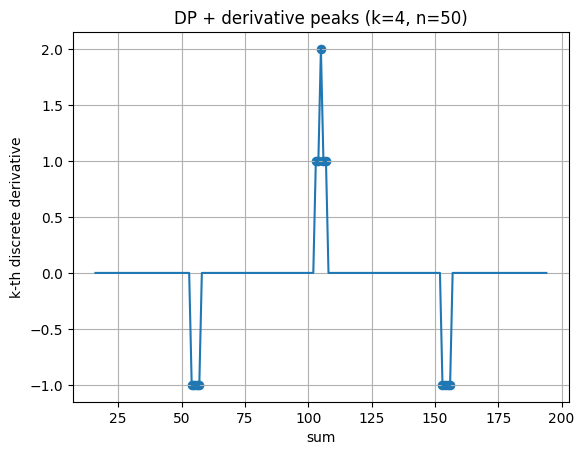

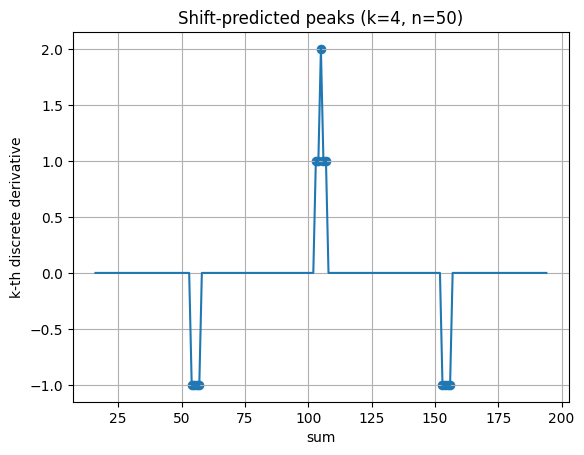

In [15]:
K = 4
TRANSIENT_MODE = "step_indexed"
DEFAULT_TARGET_N = 50
result = run_experiment(K, transient_mode=TRANSIENT_MODE, n_target=DEFAULT_TARGET_N)

